# ZGX Nano Inference Performance Testing

This notebook tests the inference performance of the HP ZGX Nano AI Station with Ollama, specifically testing the `gpt-oss:20b` model served locally on port 11434.

## Test Coverage

- **Ollama API Endpoints**: Tests various Ollama API endpoints (generate, chat, embeddings) using the official Ollama Python library
- **Performance Metrics**: Latency, throughput, tokens/second, system resource usage
- **Test Scenarios**: Short prompts, long prompts, batch requests, streaming
- **Performance Analysis**: Comprehensive analysis with visualizations


In [1]:
import subprocess
import sys
import ollama
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Optional, Tuple
import statistics
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# System monitoring
import psutil
try:
    import pynvml
    GPU_MONITORING_AVAILABLE = True
    pynvml.nvmlInit()
except ImportError:
    GPU_MONITORING_AVAILABLE = False
    print("GPU monitoring not available. Install nvidia-ml-py3 for GPU metrics.")

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful")
print(f"✓ GPU monitoring: {'Available' if GPU_MONITORING_AVAILABLE else 'Not available'}")


✓ All imports successful
✓ GPU monitoring: Available


In [2]:
# Configuration
# Ollama library automatically uses localhost:11434 by default
# You can set a custom host with: ollama.Client(host='http://localhost:11434')
OLLAMA_BASE_URL = "http://localhost:11434"
MODEL_NAME = "gpt-oss:20b"

# Test configuration
NUM_ITERATIONS = 5  # Number of runs per test scenario
WARMUP_ITERATIONS = 2  # Warmup runs before actual testing

# Test prompts
SHORT_PROMPT = "What is artificial intelligence?"
MEDIUM_PROMPT = "Explain the concept of machine learning, including supervised and unsupervised learning, with examples."
LONG_PROMPT = """Write a comprehensive guide about deep learning neural networks. Include information about:
1. The architecture of neural networks
2. Different types of layers (convolutional, recurrent, attention)
3. Training processes and backpropagation
4. Common activation functions
5. Regularization techniques
6. Applications in computer vision and natural language processing
Please provide detailed explanations with examples."""

BATCH_PROMPTS = [
    "What is Python?",
    "Explain quantum computing.",
    "Describe the water cycle.",
    "What is photosynthesis?",
    "Explain the theory of relativity.",
]

print(f"Configuration:")
print(f"  Ollama URL: {OLLAMA_BASE_URL}")
print(f"  Model: {MODEL_NAME}")
print(f"  Iterations per test: {NUM_ITERATIONS}")
print(f"  Warmup iterations: {WARMUP_ITERATIONS}")


Configuration:
  Ollama URL: http://localhost:11434
  Model: gpt-oss:20b
  Iterations per test: 5
  Warmup iterations: 2


In [3]:
class PerformanceMonitor:
    """Monitor system performance during inference tests."""
    
    def __init__(self):
        self.gpu_available = GPU_MONITORING_AVAILABLE
        if self.gpu_available:
            try:
                self.handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            except:
                self.gpu_available = False
    
    def get_cpu_usage(self) -> float:
        """Get current CPU usage percentage."""
        return psutil.cpu_percent(interval=0.1)
    
    def get_memory_usage(self) -> Dict[str, float]:
        """Get memory usage statistics."""
        mem = psutil.virtual_memory()
        return {
            "total_gb": mem.total / (1024**3),
            "used_gb": mem.used / (1024**3),
            "available_gb": mem.available / (1024**3),
            "percent": mem.percent
        }
    
    def get_gpu_usage(self) -> Optional[Dict[str, float]]:
        """Get GPU usage statistics."""
        if not self.gpu_available:
            return None
        
        gpu_stats = {}
        
        # Get utilization rates (GPU and memory)
        try:
            util = pynvml.nvmlDeviceGetUtilizationRates(self.handle)
            gpu_stats["gpu_utilization_percent"] = float(util.gpu)
            gpu_stats["memory_utilization_percent"] = float(util.memory)
        except Exception as e:
            # If utilization fails, we can't get basic GPU stats
            # Don't print warning here as it might be called frequently
            return None
        
        # Get memory info
        try:
            mem_info = pynvml.nvmlDeviceGetMemoryInfo(self.handle)
            gpu_stats["memory_used_gb"] = float(mem_info.used / (1024**3))
            gpu_stats["memory_total_gb"] = float(mem_info.total / (1024**3))
        except Exception as e:
            # Memory info is critical, but continue if it fails
            pass
        
        # Get temperature (optional - not all GPUs support this)
        try:
            temp = pynvml.nvmlDeviceGetTemperature(self.handle, pynvml.NVML_TEMPERATURE_GPU)
            gpu_stats["temperature_celsius"] = float(temp)
        except Exception as e:
            # Temperature is optional - some GPUs don't support it
            # Silently skip if "Not Supported" or any other error occurs
            # This is common for virtual GPUs, some embedded GPUs, or systems without temp sensors
            pass
        
        # Return stats if we got at least utilization data
        if gpu_stats:
            return gpu_stats
        else:
            return None
    
    def get_system_stats(self) -> Dict:
        """Get comprehensive system statistics."""
        stats = {
            "cpu_percent": self.get_cpu_usage(),
            "memory": self.get_memory_usage(),
            "timestamp": time.time()
        }
        
        gpu_stats = self.get_gpu_usage()
        if gpu_stats:
            stats["gpu"] = gpu_stats
        
        return stats

# Initialize monitor
monitor = PerformanceMonitor()
print("✓ Performance monitor initialized")


✓ Performance monitor initialized


In [4]:
class OllamaPerformanceTester:
    """Test Ollama API endpoints and measure performance using the official Ollama library."""
    
    def __init__(self, model_name: str, host: Optional[str] = None):
        self.model_name = model_name
        self.results = []
        self.monitor = PerformanceMonitor()
        # Initialize Ollama client (defaults to localhost:11434)
        if host:
            self.client = ollama.Client(host=host)
        else:
            self.client = ollama.Client()
    
    def check_ollama_connection(self) -> bool:
        """Check if Ollama is running and accessible."""
        try:
            response = self.client.list()
            # Handle different response structures
            # The response might be a dict with "models" key, or an object with .models attribute
            if hasattr(response, 'models'):
                models_list = response.models
            elif isinstance(response, dict) and 'models' in response:
                models_list = response['models']
            elif isinstance(response, list):
                models_list = response
            else:
                # Try to access as dict
                models_list = response.get('models', []) if isinstance(response, dict) else []
            
            # Extract model names - handle both dict and object formats
            model_names = []
            for m in models_list:
                if isinstance(m, dict):
                    name = m.get("name", "") or m.get("model", "")
                elif hasattr(m, 'name'):
                    name = m.name
                elif hasattr(m, 'model'):
                    name = m.model
                else:
                    name = str(m)
                if name:
                    model_names.append(name)
            
            print(f"✓ Ollama is running")
            if model_names:
                print(f"  Available models: {', '.join(model_names)}")
            else:
                print(f"  Available models: (none found)")
            
            # Check if model is in the list (exact match or name without tag)
            model_found = False
            if self.model_name in model_names:
                model_found = True
            else:
                # Try matching without tag (e.g., "gpt-oss:20b" vs "gpt-oss")
                model_base = self.model_name.split(':')[0]
                for name in model_names:
                    if name == self.model_name or name.startswith(model_base + ':'):
                        model_found = True
                        break
            
            if model_found:
                print(f"✓ Target model '{self.model_name}' is available")
                return True
            else:
                print(f"⚠ Warning: Model '{self.model_name}' not found in available models")
                # Also check if model is accessible by trying a simple request
                # This handles cases where model is loaded but not in the list
                try:
                    # Try to get model info or make a minimal test request
                    test_response = self.client.generate(
                        model=self.model_name,
                        prompt="test",
                        options={"num_predict": 1}
                    )
                    if test_response:
                        print(f"  ✓ Model '{self.model_name}' is accessible (may not be in list)")
                        return True
                except Exception as test_error:
                    # If that fails, try show() method if available
                    try:
                        if hasattr(self.client, 'show'):
                            self.client.show(model=self.model_name)
                            print(f"  ✓ Model '{self.model_name}' exists (may not be in list)")
                            return True
                    except:
                        pass
                    print(f"  ✗ Model verification failed: {test_error}")
                return False
        except Exception as e:
            print(f"✗ Cannot connect to Ollama: {e}")
            import traceback
            traceback.print_exc()
            return False
    
    def generate_request(self, prompt: str, stream: bool = False, **kwargs) -> Dict:
        """Make a generate request to Ollama."""
        start_time = time.time()
        system_stats_before = self.monitor.get_system_stats()
        
        try:
            response = self.client.generate(
                model=self.model_name,
                prompt=prompt,
                stream=stream,
                **kwargs
            )
            end_time = time.time()
            
            system_stats_after = self.monitor.get_system_stats()
            latency = end_time - start_time
            
            # Count tokens (rough estimate)
            response_text = response.get("response", "")
            input_tokens = len(prompt.split())
            output_tokens = len(response_text.split())
            total_tokens = input_tokens + output_tokens
            
            tokens_per_second = output_tokens / latency if latency > 0 else 0
            
            return {
                "success": True,
                "latency_seconds": latency,
                "input_tokens": input_tokens,
                "output_tokens": output_tokens,
                "total_tokens": total_tokens,
                "tokens_per_second": tokens_per_second,
                "response_length": len(response_text),
                "system_stats_before": system_stats_before,
                "system_stats_after": system_stats_after,
                "response_preview": response_text[:200] + "..." if len(response_text) > 200 else response_text
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e),
                "latency_seconds": time.time() - start_time
            }
    
    def chat_request(self, messages: List[Dict], stream: bool = False) -> Dict:
        """Make a chat request to Ollama."""
        start_time = time.time()
        system_stats_before = self.monitor.get_system_stats()
        
        try:
            response = self.client.chat(
                model=self.model_name,
                messages=messages,
                stream=stream
            )
            end_time = time.time()
            
            system_stats_after = self.monitor.get_system_stats()
            latency = end_time - start_time
            
            message = response.get("message", {})
            response_text = message.get("content", "")
            
            # Count tokens
            total_input = sum(len(msg.get("content", "").split()) for msg in messages)
            output_tokens = len(response_text.split())
            total_tokens = total_input + output_tokens
            
            tokens_per_second = output_tokens / latency if latency > 0 else 0
            
            return {
                "success": True,
                "latency_seconds": latency,
                "input_tokens": total_input,
                "output_tokens": output_tokens,
                "total_tokens": total_tokens,
                "tokens_per_second": tokens_per_second,
                "response_length": len(response_text),
                "system_stats_before": system_stats_before,
                "system_stats_after": system_stats_after,
                "response_preview": response_text[:200] + "..." if len(response_text) > 200 else response_text
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e),
                "latency_seconds": time.time() - start_time
            }
    
    def embeddings_request(self, prompt: str) -> Dict:
        """Make an embeddings request to Ollama."""
        start_time = time.time()
        system_stats_before = self.monitor.get_system_stats()
        
        try:
            response = self.client.embeddings(
                model=self.model_name,
                prompt=prompt
            )
            end_time = time.time()
            
            system_stats_after = self.monitor.get_system_stats()
            latency = end_time - start_time
            embedding = response.get("embedding", [])
            
            return {
                "success": True,
                "latency_seconds": latency,
                "embedding_dimension": len(embedding),
                "system_stats_before": system_stats_before,
                "system_stats_after": system_stats_after
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e),
                "latency_seconds": time.time() - start_time
            }
    
    def run_test_scenario(self, scenario_name: str, test_func, *args, **kwargs) -> List[Dict]:
        """Run a test scenario multiple times and collect results."""
        print(f"\n{'='*60}")
        print(f"Running scenario: {scenario_name}")
        print(f"{'='*60}")
        
        # Warmup
        print(f"Warming up ({WARMUP_ITERATIONS} iterations)...")
        for _ in range(WARMUP_ITERATIONS):
            test_func(*args, **kwargs)
            time.sleep(0.5)
        
        # Actual test runs
        results = []
        print(f"Running tests ({NUM_ITERATIONS} iterations)...")
        for i in range(NUM_ITERATIONS):
            print(f"  Iteration {i+1}/{NUM_ITERATIONS}...", end=" ", flush=True)
            result = test_func(*args, **kwargs)
            result["scenario"] = scenario_name
            result["iteration"] = i + 1
            result["timestamp"] = datetime.now().isoformat()
            results.append(result)
            
            if result.get("success"):
                print(f"✓ ({result.get('latency_seconds', 0):.2f}s, {result.get('tokens_per_second', 0):.1f} tok/s)")
            else:
                print(f"✗ Error: {result.get('error', 'Unknown')}")
            
            time.sleep(0.5)  # Small delay between requests
        
        self.results.extend(results)
        return results

# Initialize tester
tester = OllamaPerformanceTester(MODEL_NAME)
print("✓ Ollama performance tester initialized")


✓ Ollama performance tester initialized


## Step 1: Verify Ollama Connection

First, let's verify that Ollama is running and the model is available.


In [5]:
# Check Ollama connection
if not tester.check_ollama_connection():
    print("\n⚠ Please ensure Ollama is running and the model is available.")
    print(f"   Start Ollama and pull the model with: ollama pull {MODEL_NAME}")
else:
    print("\n✓ Ready to run performance tests!")


✓ Ollama is running
  Available models: gpt-oss:20b
✓ Target model 'gpt-oss:20b' is available

✓ Ready to run performance tests!


## Step 2: Test Scenarios

We'll run several test scenarios to evaluate different aspects of performance.


In [6]:
# Scenario 1: Short Prompt Generation
tester.run_test_scenario(
    "Short Prompt (Generate)",
    tester.generate_request,
    SHORT_PROMPT
)



Running scenario: Short Prompt (Generate)
Warming up (2 iterations)...
Running tests (5 iterations)...
  Iteration 1/5... ✓ (24.75s, 32.9 tok/s)
  Iteration 2/5... ✓ (16.32s, 34.6 tok/s)
  Iteration 3/5... ✓ (16.66s, 27.7 tok/s)
  Iteration 4/5... ✓ (19.47s, 29.9 tok/s)
  Iteration 5/5... ✓ (11.84s, 33.3 tok/s)


[{'success': True,
  'latency_seconds': 24.75411891937256,
  'input_tokens': 4,
  'output_tokens': 814,
  'total_tokens': 818,
  'tokens_per_second': 32.88341639834994,
  'response_length': 5743,
  'system_stats_before': {'cpu_percent': 1.5,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.295570373535156,
    'available_gb': 99.3395881652832,
    'percent': 17.0},
   'timestamp': 1763979584.3332057,
   'gpu': {'gpu_utilization_percent': 0.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 52.0}},
  'system_stats_after': {'cpu_percent': 0.5,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.285438537597656,
    'available_gb': 99.3497200012207,
    'percent': 17.0},
   'timestamp': 1763979609.0885482,
   'gpu': {'gpu_utilization_percent': 93.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 59.0}},
  'response_preview': '**Artificial intelligence (AI)** is the field of computer science that seeks to create machines—softw

In [7]:
# Scenario 2: Medium Prompt Generation
tester.run_test_scenario(
    "Medium Prompt (Generate)",
    tester.generate_request,
    MEDIUM_PROMPT
)



Running scenario: Medium Prompt (Generate)
Warming up (2 iterations)...
Running tests (5 iterations)...
  Iteration 1/5... ✓ (21.78s, 34.7 tok/s)
  Iteration 2/5... ✓ (30.68s, 29.3 tok/s)
  Iteration 3/5... ✓ (21.34s, 36.9 tok/s)
  Iteration 4/5... ✓ (24.58s, 34.0 tok/s)
  Iteration 5/5... ✓ (29.62s, 32.2 tok/s)


[{'success': True,
  'latency_seconds': 21.7753324508667,
  'input_tokens': 13,
  'output_tokens': 755,
  'total_tokens': 768,
  'tokens_per_second': 34.67226053625416,
  'response_length': 4981,
  'system_stats_before': {'cpu_percent': 0.0,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.294879913330078,
    'available_gb': 99.34027862548828,
    'percent': 17.0},
   'timestamp': 1763979750.3955698,
   'gpu': {'gpu_utilization_percent': 93.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 59.0}},
  'system_stats_after': {'cpu_percent': 1.5,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.30752182006836,
    'available_gb': 99.32763671875,
    'percent': 17.0},
   'timestamp': 1763979772.1703947,
   'gpu': {'gpu_utilization_percent': 94.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 62.0}},
  'response_preview': '## Machine Learning in a Nutshell\n\nAt its core, **machine learning (ML)** is a branch of artificial 

In [8]:
# Scenario 3: Long Prompt Generation
tester.run_test_scenario(
    "Long Prompt (Generate)",
    tester.generate_request,
    LONG_PROMPT
)



Running scenario: Long Prompt (Generate)
Warming up (2 iterations)...
Running tests (5 iterations)...
  Iteration 1/5... ✓ (73.81s, 26.6 tok/s)
  Iteration 2/5... ✓ (107.22s, 26.8 tok/s)
  Iteration 3/5... ✓ (90.24s, 24.4 tok/s)
  Iteration 4/5... ✓ (83.46s, 24.1 tok/s)
  Iteration 5/5... ✓ (94.37s, 24.2 tok/s)


[{'success': True,
  'latency_seconds': 73.81352972984314,
  'input_tokens': 53,
  'output_tokens': 1963,
  'total_tokens': 2016,
  'tokens_per_second': 26.594040512417745,
  'response_length': 14374,
  'system_stats_before': {'cpu_percent': 0.0,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.33535385131836,
    'available_gb': 99.2998046875,
    'percent': 17.0},
   'timestamp': 1763980288.4796596,
   'gpu': {'gpu_utilization_percent': 94.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 66.0}},
  'system_stats_after': {'cpu_percent': 0.0,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.35942840576172,
    'available_gb': 99.27573013305664,
    'percent': 17.0},
   'timestamp': 1763980362.293296,
   'gpu': {'gpu_utilization_percent': 94.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 69.0}},
  'response_preview': '# Deep Learning Neural Networks – A Comprehensive Guide  \n\n*(Updated 2025)*  \n\nDeep learning is 

In [9]:
# Scenario 4: Chat API
tester.run_test_scenario(
    "Chat API",
    tester.chat_request,
    [{"role": "user", "content": MEDIUM_PROMPT}]
)



Running scenario: Chat API
Warming up (2 iterations)...
Running tests (5 iterations)...
  Iteration 1/5... ✓ (27.90s, 33.8 tok/s)
  Iteration 2/5... ✓ (26.36s, 28.6 tok/s)
  Iteration 3/5... ✓ (38.42s, 30.9 tok/s)
  Iteration 4/5... ✓ (26.92s, 29.9 tok/s)
  Iteration 5/5... ✓ (26.54s, 30.5 tok/s)


[{'success': True,
  'latency_seconds': 27.901862382888794,
  'input_tokens': 13,
  'output_tokens': 944,
  'total_tokens': 957,
  'tokens_per_second': 33.83286703395545,
  'response_length': 6358,
  'system_stats_before': {'cpu_percent': 1.0,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.190937042236328,
    'available_gb': 99.44422149658203,
    'percent': 16.9},
   'timestamp': 1763981138.6589994,
   'gpu': {'gpu_utilization_percent': 93.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 61.0}},
  'system_stats_after': {'cpu_percent': 0.5,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.224102020263672,
    'available_gb': 99.41105651855469,
    'percent': 16.9},
   'timestamp': 1763981166.5619323,
   'gpu': {'gpu_utilization_percent': 93.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 68.0}},
  'response_preview': '### What is Machine Learning?\n\nAt its core, **machine learning (ML)** is a set of algorithms t

In [10]:
# Scenario 5: Multi-turn Chat
tester.run_test_scenario(
    "Multi-turn Chat",
    tester.chat_request,
    [
        {"role": "user", "content": "What is machine learning?"},
        {"role": "assistant", "content": "Machine learning is a subset of artificial intelligence..."},
        {"role": "user", "content": "Can you give me an example?"}
    ]
)



Running scenario: Multi-turn Chat
Warming up (2 iterations)...
Running tests (5 iterations)...
  Iteration 1/5... ✓ (12.17s, 35.3 tok/s)
  Iteration 2/5... ✓ (10.61s, 23.0 tok/s)
  Iteration 3/5... ✓ (11.35s, 37.1 tok/s)
  Iteration 4/5... ✓ (21.60s, 32.9 tok/s)
  Iteration 5/5... ✓ (15.41s, 30.7 tok/s)


[{'success': True,
  'latency_seconds': 12.168403387069702,
  'input_tokens': 18,
  'output_tokens': 429,
  'total_tokens': 447,
  'tokens_per_second': 35.25524149337955,
  'response_length': 2786,
  'system_stats_before': {'cpu_percent': 0.5,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.263652801513672,
    'available_gb': 99.37150573730469,
    'percent': 16.9},
   'timestamp': 1763981394.7388608,
   'gpu': {'gpu_utilization_percent': 94.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 59.0}},
  'system_stats_after': {'cpu_percent': 1.0,
   'memory': {'total_gb': 119.63515853881836,
    'used_gb': 20.273014068603516,
    'available_gb': 99.36214447021484,
    'percent': 16.9},
   'timestamp': 1763981406.9072635,
   'gpu': {'gpu_utilization_percent': 92.0,
    'memory_utilization_percent': 0.0,
    'temperature_celsius': 65.0}},
  'response_preview': '**Example: Spam‑Email Detection (a classic supervised learning task)**  \n\n| Stage | What happe

In [11]:
# Scenario 6: Batch Requests (Sequential)
print(f"\n{'='*60}")
print(f"Running scenario: Batch Requests (Sequential)")
print(f"{'='*60}")

batch_results = []
for i, prompt in enumerate(BATCH_PROMPTS):
    print(f"  Batch item {i+1}/{len(BATCH_PROMPTS)}: {prompt[:50]}...")
    result = tester.generate_request(prompt)
    result["scenario"] = "Batch Requests (Sequential)"
    result["batch_index"] = i + 1
    result["timestamp"] = datetime.now().isoformat()
    batch_results.append(result)
    time.sleep(0.5)

tester.results.extend(batch_results)
print(f"✓ Completed {len(BATCH_PROMPTS)} batch requests")



Running scenario: Batch Requests (Sequential)
  Batch item 1/5: What is Python?...
  Batch item 2/5: Explain quantum computing....
  Batch item 3/5: Describe the water cycle....
  Batch item 4/5: What is photosynthesis?...
  Batch item 5/5: Explain the theory of relativity....
✓ Completed 5 batch requests


## Step 3: Performance Monitoring Data

Let's examine the collected performance data.


In [12]:
# Convert results to DataFrame for analysis
def prepare_results_df(results: List[Dict]) -> pd.DataFrame:
    """Convert test results to a pandas DataFrame."""
    rows = []
    for result in results:
        if not result.get("success"):
            continue
        
        row = {
            "scenario": result.get("scenario", "Unknown"),
            "iteration": result.get("iteration", 0),
            "latency_seconds": result.get("latency_seconds", 0),
            "tokens_per_second": result.get("tokens_per_second", 0),
            "input_tokens": result.get("input_tokens", 0),
            "output_tokens": result.get("output_tokens", 0),
            "total_tokens": result.get("total_tokens", 0),
            "response_length": result.get("response_length", 0),
        }
        
        # Add system stats
        stats_after = result.get("system_stats_after", {})
        row["cpu_percent"] = stats_after.get("cpu_percent", 0)
        
        memory = stats_after.get("memory", {})
        row["memory_used_gb"] = memory.get("used_gb", 0)
        row["memory_percent"] = memory.get("percent", 0)
        
        # Extract GPU data - check both stats_after and stats_before
        gpu = stats_after.get("gpu")
        if not gpu:
            # Try stats_before as fallback
            stats_before = result.get("system_stats_before", {})
            gpu = stats_before.get("gpu")
        
        if gpu:
            row["gpu_utilization"] = gpu.get("gpu_utilization_percent", 0)
            row["gpu_memory_utilization"] = gpu.get("memory_utilization_percent", 0)
            row["gpu_memory_used_gb"] = gpu.get("memory_used_gb", 0)
            row["gpu_memory_total_gb"] = gpu.get("memory_total_gb", 0)
            row["gpu_temperature"] = gpu.get("temperature_celsius", 0)
        else:
            # Initialize GPU columns with NaN if not available
            row["gpu_utilization"] = None
            row["gpu_memory_utilization"] = None
            row["gpu_memory_used_gb"] = None
            row["gpu_memory_total_gb"] = None
            row["gpu_temperature"] = None
        
        rows.append(row)
    
    return pd.DataFrame(rows)

df = prepare_results_df(tester.results)
print(f"✓ Collected {len(df)} successful test results")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head(10)

✓ Collected 30 successful test results

DataFrame shape: (30, 16)

Columns: ['scenario', 'iteration', 'latency_seconds', 'tokens_per_second', 'input_tokens', 'output_tokens', 'total_tokens', 'response_length', 'cpu_percent', 'memory_used_gb', 'memory_percent', 'gpu_utilization', 'gpu_memory_utilization', 'gpu_memory_used_gb', 'gpu_memory_total_gb', 'gpu_temperature']


,scenario,iteration,latency_seconds,tokens_per_second,input_tokens,output_tokens,total_tokens,response_length,cpu_percent,memory_used_gb,memory_percent,gpu_utilization,gpu_memory_utilization,gpu_memory_used_gb,gpu_memory_total_gb,gpu_temperature
0,Short Prompt (Generate),1,24.754119,32.883416,4,814,818,5743,0.5,20.285439,17.0,93.0,0.0,0,0,59.0
1,Short Prompt (Generate),2,16.323764,34.612116,4,565,569,3904,1.0,20.288795,17.0,93.0,0.0,0,0,60.0
2,Short Prompt (Generate),3,16.661346,27.728851,4,462,466,3415,0.5,20.281013,17.0,93.0,0.0,0,0,61.0
3,Short Prompt (Generate),4,19.468287,29.946138,4,583,587,3875,0.5,20.282330,17.0,91.0,0.0,0,0,62.0
4,Short Prompt (Generate),5,11.838315,33.281763,4,394,398,2915,1.0,20.288570,17.0,93.0,0.0,0,0,62.0
5,Medium Prompt (Generate),1,21.775332,34.672261,13,755,768,4981,1.5,20.307522,17.0,94.0,0.0,0,0,62.0
6,Medium Prompt (Generate),2,30.683310,29.266725,13,898,911,6216,0.0,20.292835,17.0,93.0,0.0,0,0,66.0
7,Medium Prompt (Generate),3,21.339979,36.879137,13,787,800,5310,0.0,20.308678,17.0,94.0,0.0,0,0,67.0
8,Medium Prompt (Generate),4,24.580977,34.010040,13,836,849,5588,0.5,20.294289,17.0,94.0,0.0,0,0,68.0
9,Medium Prompt (Generate),5,29.621313,32.206540,13,954,967,6624,0.0,20.293190,17.0,94.0,0.0,0,0,69.0


In [13]:
# Summary statistics by scenario
if len(df) > 0:
    summary = df.groupby("scenario").agg({
        "latency_seconds": ["mean", "std", "min", "max"],
        "tokens_per_second": ["mean", "std", "min", "max"],
        "output_tokens": ["mean", "std"],
        "total_tokens": ["mean", "std"],
    }).round(2)
    
    print("Performance Summary by Scenario:")
    print("=" * 80)
    print(summary)
    
    # Add CPU/GPU stats if available
    if "cpu_percent" in df.columns:
        print("\n\nSystem Resource Usage by Scenario:")
        print("=" * 80)
        resource_summary = df.groupby("scenario").agg({
            "cpu_percent": ["mean", "max"],
            "memory_percent": ["mean", "max"],
        })
        if "gpu_utilization" in df.columns and df["gpu_utilization"].notna().any():
            gpu_summary = df.groupby("scenario")["gpu_utilization"].agg(["mean", "max"]).rename(columns={"mean": "gpu_utilization_mean", "max": "gpu_utilization_max"})
            resource_summary = pd.concat([resource_summary, gpu_summary], axis=1)
            if "gpu_memory_used_gb" in df.columns and df["gpu_memory_used_gb"].notna().any():
                gpu_mem_summary = df.groupby("scenario")["gpu_memory_used_gb"].agg(["mean", "max"]).rename(columns={"mean": "gpu_memory_gb_mean", "max": "gpu_memory_gb_max"})
                resource_summary = pd.concat([resource_summary, gpu_mem_summary], axis=1)
        print(resource_summary.round(2))


Performance Summary by Scenario:
                            latency_seconds                        \
                                       mean    std    min     max   
scenario                                                            
Batch Requests (Sequential)           21.90  11.79  11.81   37.11   
Chat API                              29.23   5.17  26.36   38.42   
Long Prompt (Generate)                89.82  12.45  73.81  107.22   
Medium Prompt (Generate)              25.60   4.35  21.34   30.68   
Multi-turn Chat                       14.23   4.51  10.61   21.60   
Short Prompt (Generate)               17.81   4.75  11.84   24.75   

                            tokens_per_second                      \
                                         mean   std    min    max   
scenario                                                            
Batch Requests (Sequential)             28.69  6.40  19.48  34.45   
Chat API                                30.75  1.93  28.64  33.83   


## Step 4: Visualizations

Let's create visualizations to better understand the performance characteristics.


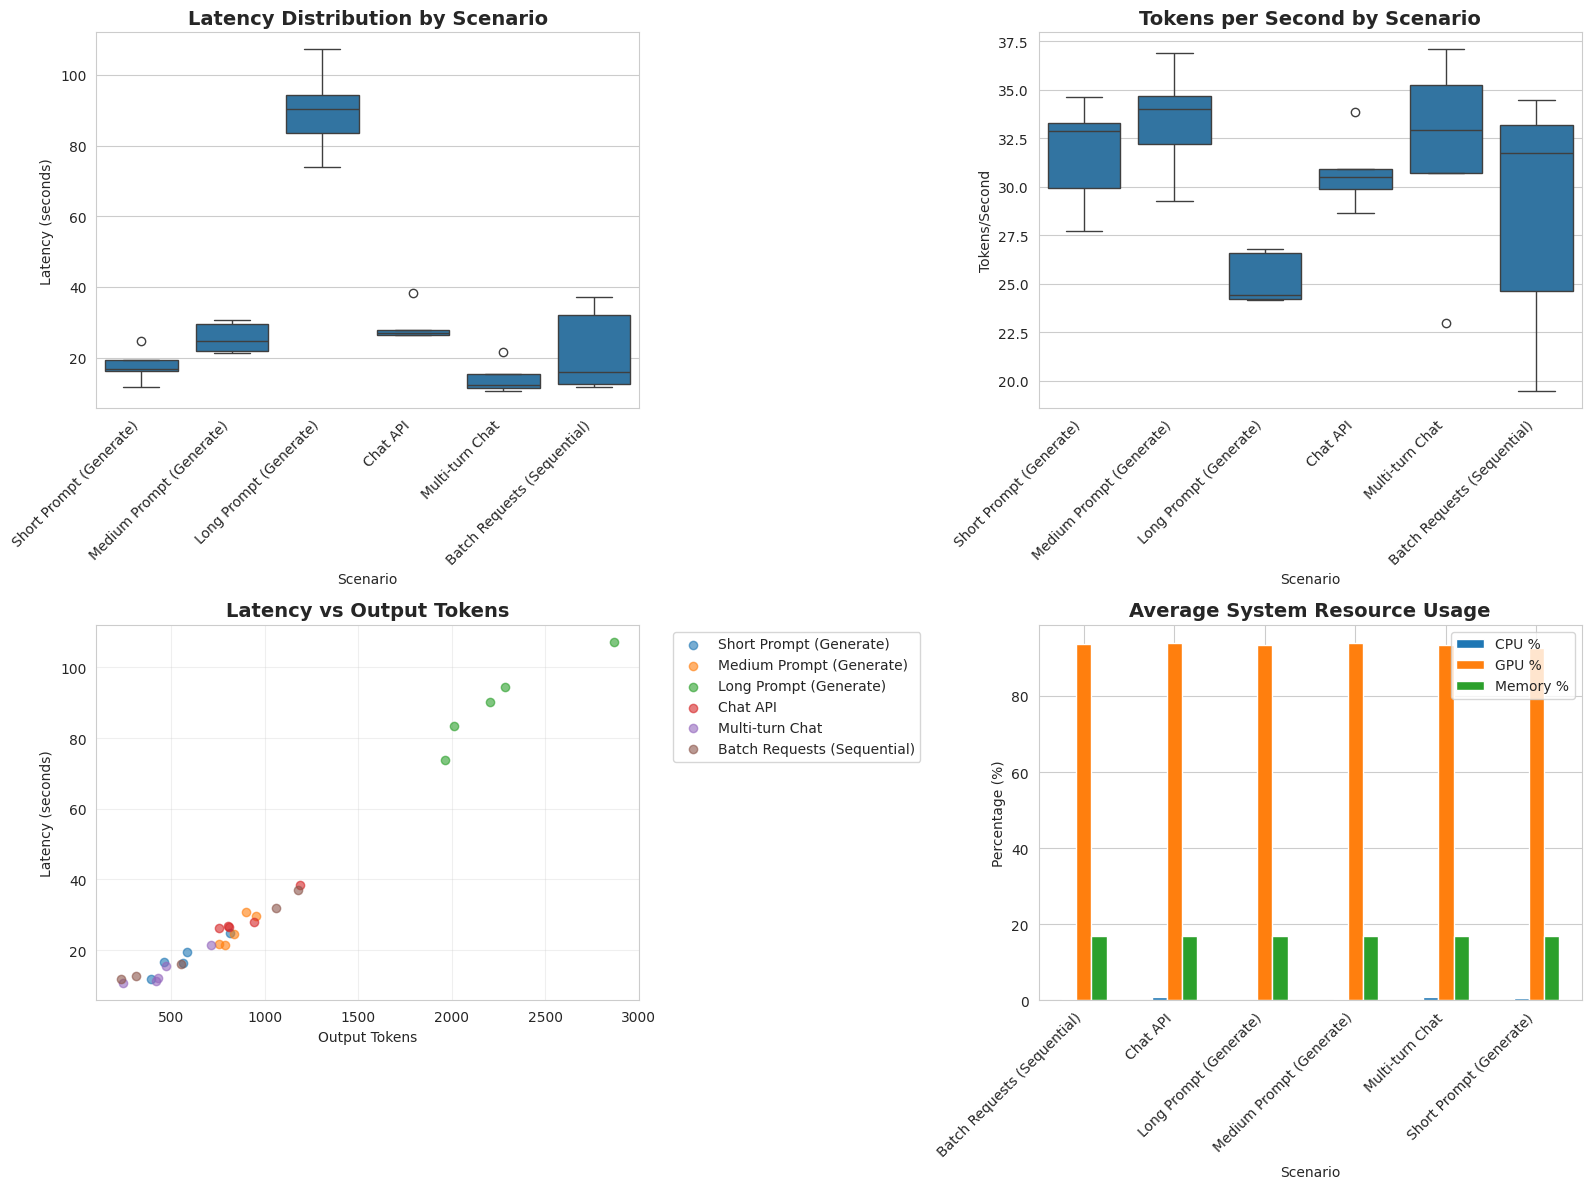

In [15]:
# Plot 1: Latency by Scenario
if len(df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Latency box plot - use seaborn for better control
    ax1 = axes[0, 0]
    sns.boxplot(data=df, x="scenario", y="latency_seconds", ax=ax1)
    ax1.set_title("Latency Distribution by Scenario", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Scenario")
    ax1.set_ylabel("Latency (seconds)")
    ax1.tick_params(axis='x', rotation=45)
    plt.setp(ax1.get_xticklabels(), ha='right')
    
    # Tokens per second
    ax2 = axes[0, 1]
    sns.boxplot(data=df, x="scenario", y="tokens_per_second", ax=ax2)
    ax2.set_title("Tokens per Second by Scenario", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Scenario")
    ax2.set_ylabel("Tokens/Second")
    ax2.tick_params(axis='x', rotation=45)
    plt.setp(ax2.get_xticklabels(), ha='right')
    
    # Latency vs Output Tokens
    ax3 = axes[1, 0]
    for scenario in df["scenario"].unique():
        scenario_data = df[df["scenario"] == scenario]
        ax3.scatter(scenario_data["output_tokens"], scenario_data["latency_seconds"], 
                   label=scenario, alpha=0.6)
    ax3.set_xlabel("Output Tokens")
    ax3.set_ylabel("Latency (seconds)")
    ax3.set_title("Latency vs Output Tokens", fontsize=14, fontweight='bold')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # System resource usage
    ax4 = axes[1, 1]
    if "gpu_utilization" in df.columns and df["gpu_utilization"].notna().any():
        resource_data = df.groupby("scenario").agg({
            "cpu_percent": "mean",
            "gpu_utilization": "mean",
            "memory_percent": "mean"
        })
        resource_data.plot(kind="bar", ax=ax4, rot=45)
        ax4.set_title("Average System Resource Usage", fontsize=14, fontweight='bold')
        ax4.set_ylabel("Percentage (%)")
        ax4.set_xlabel("Scenario")
        ax4.legend(["CPU %", "GPU %", "Memory %"])
        ax4.tick_params(axis='x', rotation=45)
        plt.setp(ax4.get_xticklabels(), ha='right')
    else:
        resource_data = df.groupby("scenario").agg({
            "cpu_percent": "mean",
            "memory_percent": "mean"
        })
        resource_data.plot(kind="bar", ax=ax4, rot=45)
        ax4.set_title("Average System Resource Usage", fontsize=14, fontweight='bold')
        ax4.set_ylabel("Percentage (%)")
        ax4.set_xlabel("Scenario")
        ax4.legend(["CPU %", "Memory %"])
        ax4.tick_params(axis='x', rotation=45)
        plt.setp(ax4.get_xticklabels(), ha='right')
    
    plt.tight_layout()
    plt.show()


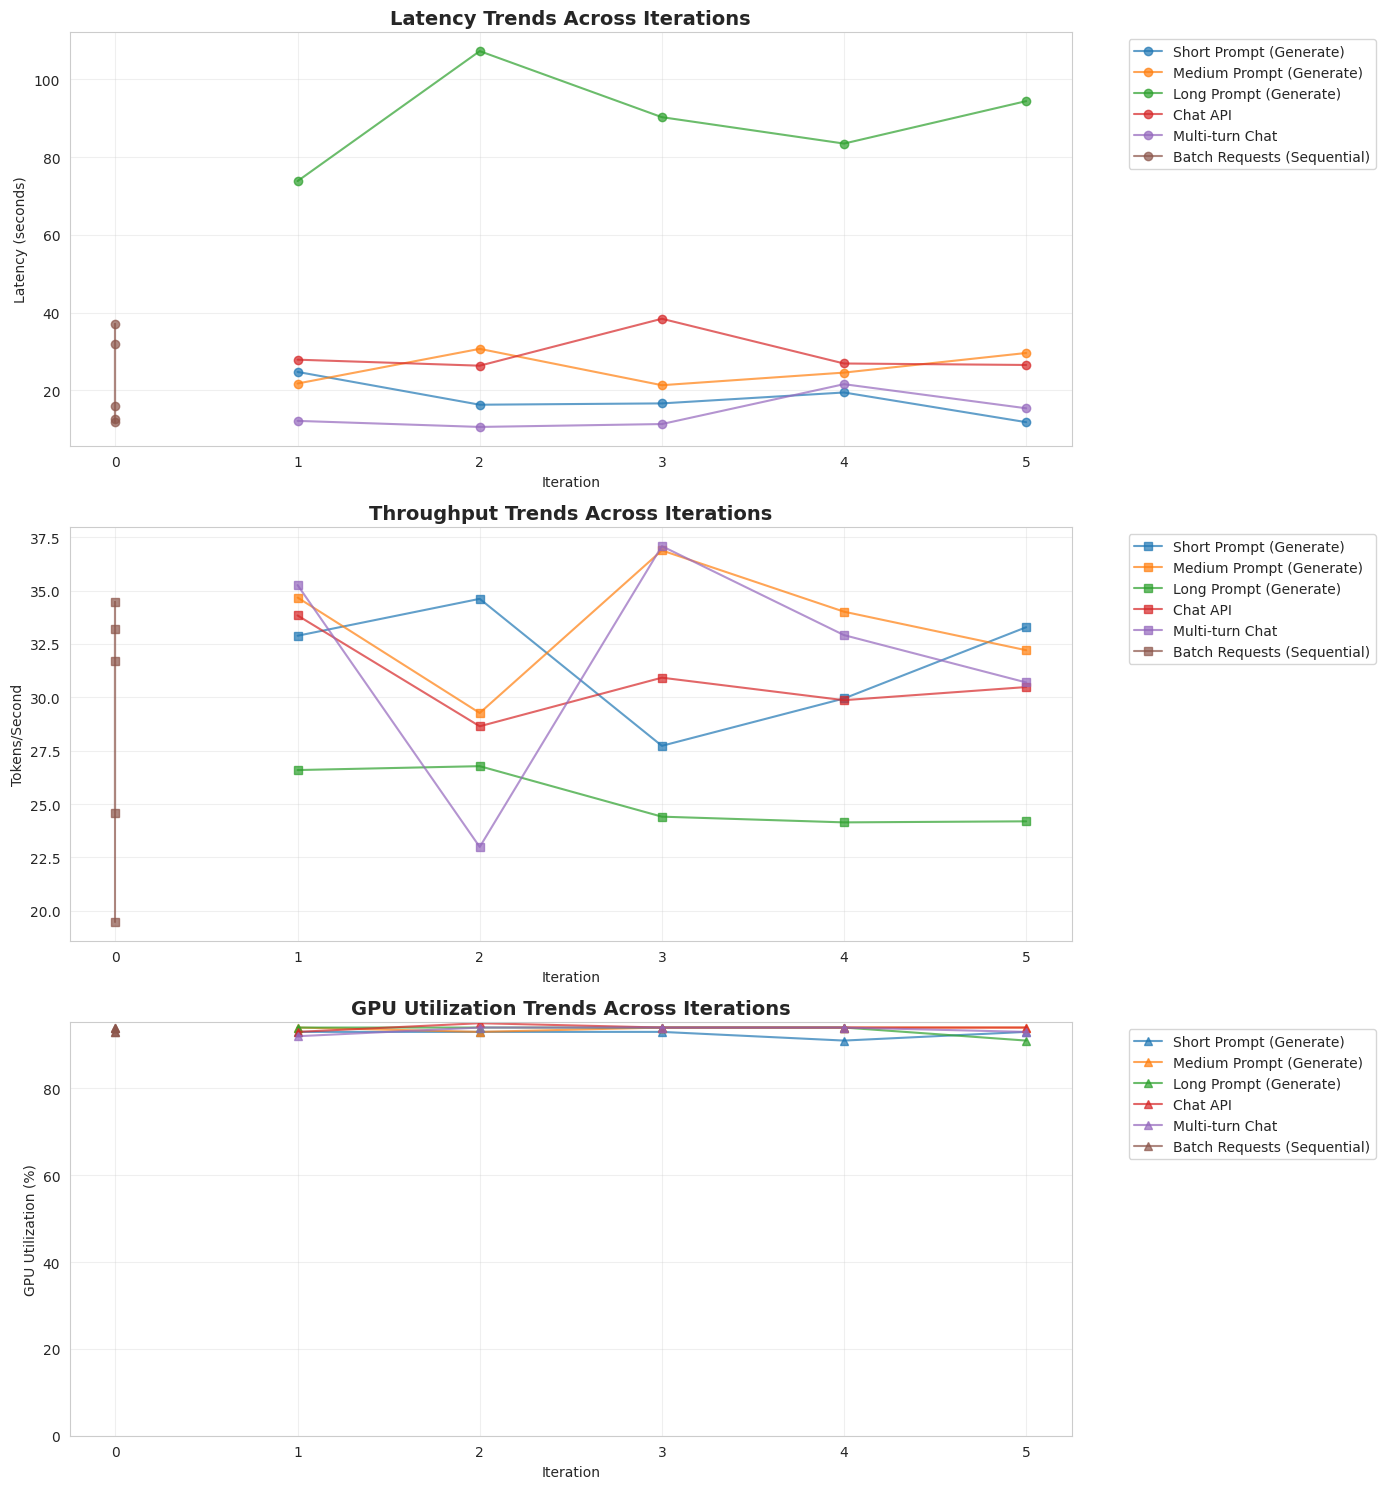

In [16]:
# Plot 2: Performance Trends
if len(df) > 0 and "iteration" in df.columns:
    # Determine number of subplots based on GPU data availability
    has_gpu_data = "gpu_utilization" in df.columns and df["gpu_utilization"].notna().any()
    n_plots = 3 if has_gpu_data else 2
    
    fig, axes = plt.subplots(n_plots, 1, figsize=(14, 5 * n_plots))
    if n_plots == 2:
        axes = [axes[0], axes[1]]
    
    # Latency over iterations
    ax1 = axes[0]
    for scenario in df["scenario"].unique():
        scenario_data = df[df["scenario"] == scenario].sort_values("iteration")
        if len(scenario_data) > 1:
            ax1.plot(scenario_data["iteration"], scenario_data["latency_seconds"], 
                    marker='o', label=scenario, alpha=0.7)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Latency (seconds)")
    ax1.set_title("Latency Trends Across Iterations", fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Tokens per second over iterations
    ax2 = axes[1]
    for scenario in df["scenario"].unique():
        scenario_data = df[df["scenario"] == scenario].sort_values("iteration")
        if len(scenario_data) > 1:
            ax2.plot(scenario_data["iteration"], scenario_data["tokens_per_second"], 
                    marker='s', label=scenario, alpha=0.7)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Tokens/Second")
    ax2.set_title("Throughput Trends Across Iterations", fontsize=14, fontweight='bold')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # GPU Utilization over iterations (if available)
    if has_gpu_data:
        ax3 = axes[2]
        for scenario in df["scenario"].unique():
            scenario_data = df[df["scenario"] == scenario].sort_values("iteration")
            scenario_data = scenario_data[scenario_data["gpu_utilization"].notna()]
            if len(scenario_data) > 1:
                ax3.plot(scenario_data["iteration"], scenario_data["gpu_utilization"], 
                        marker='^', label=scenario, alpha=0.7)
        ax3.set_xlabel("Iteration")
        ax3.set_ylabel("GPU Utilization (%)")
        ax3.set_title("GPU Utilization Trends Across Iterations", fontsize=14, fontweight='bold')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()


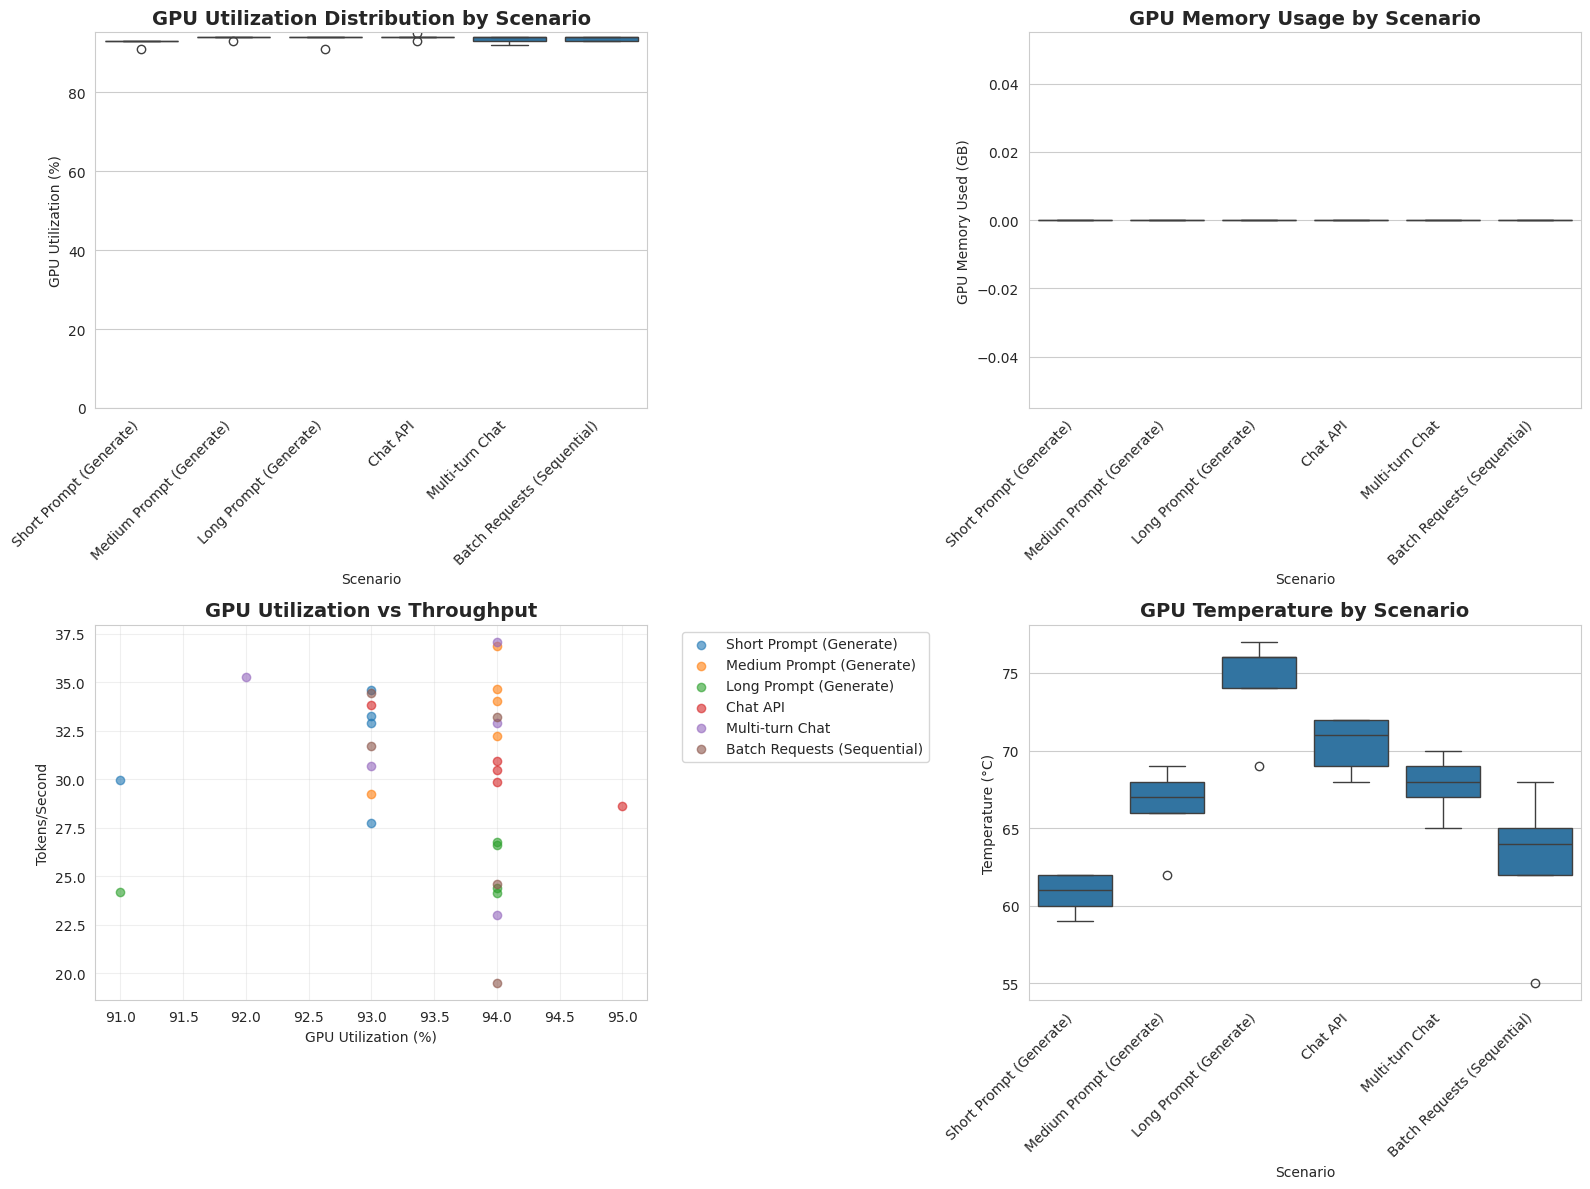

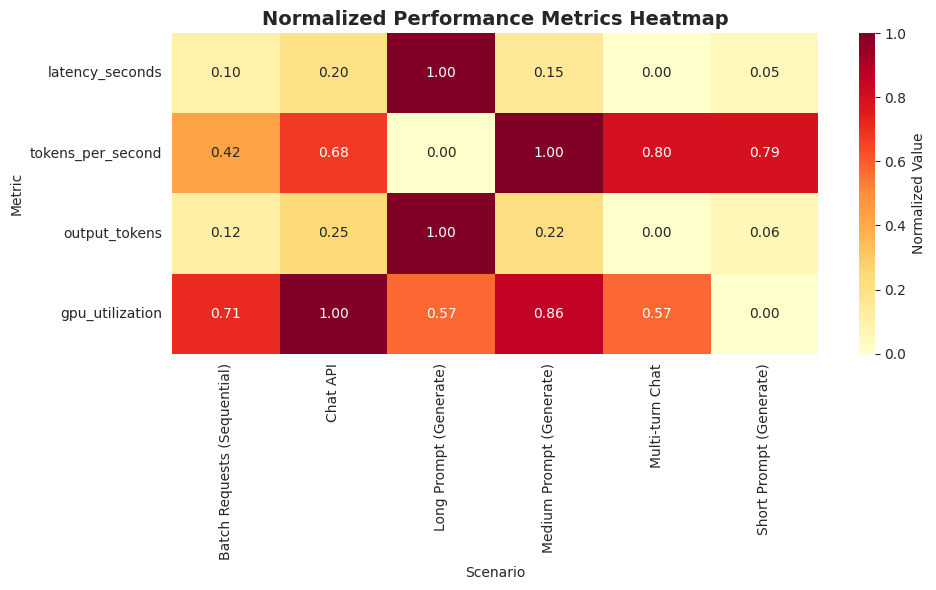

In [17]:
# Plot 3: GPU Utilization Analysis (if available)
if len(df) > 0 and "gpu_utilization" in df.columns and df["gpu_utilization"].notna().any():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # GPU Utilization by Scenario
    ax1 = axes[0, 0]
    sns.boxplot(data=df, x="scenario", y="gpu_utilization", ax=ax1)
    ax1.set_title("GPU Utilization Distribution by Scenario", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Scenario")
    ax1.set_ylabel("GPU Utilization (%)")
    ax1.tick_params(axis='x', rotation=45)
    plt.setp(ax1.get_xticklabels(), ha='right')
    ax1.set_ylim(bottom=0)
    
    # GPU Memory Usage by Scenario
    ax2 = axes[0, 1]
    if "gpu_memory_used_gb" in df.columns and df["gpu_memory_used_gb"].notna().any():
        sns.boxplot(data=df, x="scenario", y="gpu_memory_used_gb", ax=ax2)
        ax2.set_title("GPU Memory Usage by Scenario", fontsize=14, fontweight='bold')
        ax2.set_xlabel("Scenario")
        ax2.set_ylabel("GPU Memory Used (GB)")
        ax2.tick_params(axis='x', rotation=45)
        plt.setp(ax2.get_xticklabels(), ha='right')
    
    # GPU Utilization vs Throughput
    ax3 = axes[1, 0]
    for scenario in df["scenario"].unique():
        scenario_data = df[df["scenario"] == scenario]
        scenario_data = scenario_data[scenario_data["gpu_utilization"].notna()]
        if len(scenario_data) > 0:
            ax3.scatter(scenario_data["gpu_utilization"], scenario_data["tokens_per_second"], 
                       label=scenario, alpha=0.6)
    ax3.set_xlabel("GPU Utilization (%)")
    ax3.set_ylabel("Tokens/Second")
    ax3.set_title("GPU Utilization vs Throughput", fontsize=14, fontweight='bold')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # GPU Temperature (if available)
    ax4 = axes[1, 1]
    if "gpu_temperature" in df.columns and df["gpu_temperature"].notna().any():
        sns.boxplot(data=df, x="scenario", y="gpu_temperature", ax=ax4)
        ax4.set_title("GPU Temperature by Scenario", fontsize=14, fontweight='bold')
        ax4.set_xlabel("Scenario")
        ax4.set_ylabel("Temperature (°C)")
        ax4.tick_params(axis='x', rotation=45)
        plt.setp(ax4.get_xticklabels(), ha='right')
    else:
        ax4.axis('off')
        ax4.text(0.5, 0.5, "GPU Temperature data not available", 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Plot 4: Heatmap of performance metrics
if len(df) > 0:
    # Create a pivot table for heatmap
    pivot_data = df.groupby("scenario").agg({
        "latency_seconds": "mean",
        "tokens_per_second": "mean",
        "output_tokens": "mean"
    })
    
    # Add GPU utilization if available
    if "gpu_utilization" in df.columns and df["gpu_utilization"].notna().any():
        gpu_data = df.groupby("scenario")["gpu_utilization"].mean()
        pivot_data["gpu_utilization"] = gpu_data
    
    # Normalize for better visualization
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(
        scaler.fit_transform(pivot_data),
        index=pivot_data.index,
        columns=pivot_data.columns
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(normalized_data.T, annot=True, fmt='.2f', cmap='YlOrRd', 
                cbar_kws={'label': 'Normalized Value'}, 
                xticklabels=[s[:30] for s in normalized_data.index])
    plt.title("Normalized Performance Metrics Heatmap", fontsize=14, fontweight='bold')
    plt.ylabel("Metric")
    plt.xlabel("Scenario")
    plt.tight_layout()
    plt.show()


## Step 5: Final Performance Analysis

Comprehensive analysis of the ZGX Nano's performance with Ollama.


In [18]:
# Comprehensive Performance Analysis
print("=" * 80)
print("ZGX NANO PERFORMANCE ANALYSIS REPORT")
print("=" * 80)
print(f"\nModel: {MODEL_NAME}")
print(f"Test Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total Test Runs: {len(df)}")
print(f"Test Scenarios: {df['scenario'].nunique() if len(df) > 0 else 0}")

if len(df) > 0:
    print("\n" + "=" * 80)
    print("OVERALL PERFORMANCE METRICS")
    print("=" * 80)
    
    overall_stats = [
        ("Average Latency", f"{df['latency_seconds'].mean():.2f} seconds"),
        ("Median Latency", f"{df['latency_seconds'].median():.2f} seconds"),
        ("Min Latency", f"{df['latency_seconds'].min():.2f} seconds"),
        ("Max Latency", f"{df['latency_seconds'].max():.2f} seconds"),
        ("Latency Std Dev", f"{df['latency_seconds'].std():.2f} seconds"),
        (None, None),  # Spacer
        ("Average Throughput", f"{df['tokens_per_second'].mean():.2f} tokens/second"),
        ("Median Throughput", f"{df['tokens_per_second'].median():.2f} tokens/second"),
        ("Peak Throughput", f"{df['tokens_per_second'].max():.2f} tokens/second"),
        ("Throughput Std Dev", f"{df['tokens_per_second'].std():.2f} tokens/second"),
        (None, None),  # Spacer
        ("Average Output Tokens", f"{df['output_tokens'].mean():.0f} tokens"),
        ("Total Tokens Processed", f"{df['total_tokens'].sum():.0f} tokens"),
    ]
    
    for key, value in overall_stats:
        if key is None:
            print()
        else:
            print(f"  {key:.<40} {value}")
    
    print("\n" + "=" * 80)
    print("SCENARIO-SPECIFIC ANALYSIS")
    print("=" * 80)
    
    for scenario in sorted(df['scenario'].unique()):
        scenario_df = df[df['scenario'] == scenario]
        print(f"\n{scenario}:")
        print(f"  Runs: {len(scenario_df)}")
        print(f"  Avg Latency: {scenario_df['latency_seconds'].mean():.2f}s "
              f"(±{scenario_df['latency_seconds'].std():.2f}s)")
        print(f"  Avg Throughput: {scenario_df['tokens_per_second'].mean():.2f} tok/s "
              f"(±{scenario_df['tokens_per_second'].std():.2f} tok/s)")
        print(f"  Avg Output: {scenario_df['output_tokens'].mean():.0f} tokens")
        
        if "gpu_utilization" in scenario_df.columns:
            print(f"  Avg GPU Utilization: {scenario_df['gpu_utilization'].mean():.1f}%")
    
    print("\n" + "=" * 80)
    print("SYSTEM RESOURCE UTILIZATION")
    print("=" * 80)
    
    if "cpu_percent" in df.columns:
        print(f"  Average CPU Usage: {df['cpu_percent'].mean():.1f}% (max: {df['cpu_percent'].max():.1f}%)")
        print(f"  Average Memory Usage: {df['memory_percent'].mean():.1f}% (max: {df['memory_percent'].max():.1f}%)")
        
        if "gpu_utilization" in df.columns:
            print(f"  Average GPU Utilization: {df['gpu_utilization'].mean():.1f}% (max: {df['gpu_utilization'].max():.1f}%)")
            if "gpu_memory_used_gb" in df.columns:
                print(f"  Average GPU Memory: {df['gpu_memory_used_gb'].mean():.2f} GB")
            if "gpu_temperature" in df.columns:
                print(f"  Average GPU Temperature: {df['gpu_temperature'].mean():.1f}°C")
    
    print("\n" + "=" * 80)
    print("PERFORMANCE INSIGHTS")
    print("=" * 80)
    
    # Calculate insights
    insights = []
    
    # Latency consistency
    cv_latency = (df['latency_seconds'].std() / df['latency_seconds'].mean()) * 100
    if cv_latency < 10:
        insights.append("✓ Excellent latency consistency (CV < 10%)")
    elif cv_latency < 20:
        insights.append("✓ Good latency consistency (CV < 20%)")
    else:
        insights.append("⚠ Moderate latency variance (CV > 20%)")
    
    # Throughput analysis
    avg_throughput = df['tokens_per_second'].mean()
    if avg_throughput > 50:
        insights.append(f"✓ High throughput: {avg_throughput:.1f} tokens/second")
    elif avg_throughput > 20:
        insights.append(f"✓ Moderate throughput: {avg_throughput:.1f} tokens/second")
    else:
        insights.append(f"⚠ Lower throughput: {avg_throughput:.1f} tokens/second")
    
    # GPU utilization
    if "gpu_utilization" in df.columns:
        avg_gpu = df['gpu_utilization'].mean()
        if avg_gpu > 80:
            insights.append(f"✓ High GPU utilization: {avg_gpu:.1f}% (efficient use)")
        elif avg_gpu > 50:
            insights.append(f"✓ Moderate GPU utilization: {avg_gpu:.1f}%")
        else:
            insights.append(f"⚠ Low GPU utilization: {avg_gpu:.1f}% (potential for optimization)")
    
    # Best/worst scenarios
    best_latency = df.groupby('scenario')['latency_seconds'].mean().idxmin()
    worst_latency = df.groupby('scenario')['latency_seconds'].mean().idxmax()
    best_throughput = df.groupby('scenario')['tokens_per_second'].mean().idxmax()
    
    insights.append(f"  Fastest scenario: {best_latency}")
    insights.append(f"  Slowest scenario: {worst_latency}")
    insights.append(f"  Highest throughput: {best_throughput}")
    
    for insight in insights:
        print(f"  {insight}")
    
    print("\n" + "=" * 80)
    print("RECOMMENDATIONS FOR LOCAL AI DEVELOPMENT")
    print("=" * 80)
    
    recommendations = []
    
    if avg_throughput < 20:
        recommendations.append("• Consider optimizing model parameters or using quantization for better throughput")
    
    if "gpu_utilization" in df.columns and df['gpu_utilization'].mean() < 50:
        recommendations.append("• GPU utilization is low - consider batch processing or concurrent requests")
    
    if cv_latency > 20:
        recommendations.append("• High latency variance detected - investigate system resource contention")
    
    # Check if there's a significant difference between scenarios
    scenario_throughputs = df.groupby('scenario')['tokens_per_second'].mean()
    if scenario_throughputs.max() / scenario_throughputs.min() > 2:
        recommendations.append("• Significant performance variation across scenarios - optimize for your use case")
    
    if len(recommendations) == 0:
        recommendations.append("• System is performing well! Consider experimenting with batch sizes and concurrent requests.")
    
    recommendations.append("• For production workloads, monitor GPU temperature and memory usage")
    recommendations.append("• Consider implementing request queuing for better resource management")
    
    for rec in recommendations:
        print(f"  {rec}")
    
    print("\n" + "=" * 80)
else:
    print("\n⚠ No successful test results to analyze. Please check Ollama connection and model availability.")


ZGX NANO PERFORMANCE ANALYSIS REPORT

Model: gpt-oss:20b
Test Date: 2025-11-24 19:26:40
Total Test Runs: 30
Test Scenarios: 6

OVERALL PERFORMANCE METRICS
  Average Latency......................... 33.10 seconds
  Median Latency.......................... 24.67 seconds
  Min Latency............................. 10.61 seconds
  Max Latency............................. 107.22 seconds
  Latency Std Dev......................... 27.26 seconds

  Average Throughput...................... 30.26 tokens/second
  Median Throughput....................... 30.81 tokens/second
  Peak Throughput......................... 37.08 tokens/second
  Throughput Std Dev...................... 4.48 tokens/second

  Average Output Tokens................... 950 tokens
  Total Tokens Processed.................. 29015 tokens

SCENARIO-SPECIFIC ANALYSIS

Batch Requests (Sequential):
  Runs: 5
  Avg Latency: 21.90s (±11.79s)
  Avg Throughput: 28.69 tok/s (±6.40 tok/s)
  Avg Output: 666 tokens
  Avg GPU Utilization: 93.6

In [19]:
# Export results to CSV for further analysis
if len(df) > 0:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f"zgx_nano_performance_{timestamp}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"✓ Results exported to: {csv_filename}")
    
    # Also create a summary CSV
    summary_df = df.groupby("scenario").agg({
        "latency_seconds": ["mean", "std", "min", "max"],
        "tokens_per_second": ["mean", "std", "min", "max"],
        "output_tokens": ["mean"],
        "total_tokens": ["mean"],
    }).round(2)
    summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
    summary_filename = f"zgx_nano_performance_summary_{timestamp}.csv"
    summary_df.to_csv(summary_filename)
    print(f"✓ Summary exported to: {summary_filename}")


✓ Results exported to: zgx_nano_performance_20251124_192659.csv
✓ Summary exported to: zgx_nano_performance_summary_20251124_192659.csv


## Summary

This notebook provides a comprehensive performance analysis of the ZGX Nano AI Station running Ollama with the `gpt-oss:20b` model. The tests cover:

- **Multiple API endpoints**: Generate, Chat, and Embeddings
- **Various prompt lengths**: Short, medium, and long prompts
- **Different scenarios**: Single requests, multi-turn conversations, batch processing
- **System monitoring**: CPU, memory, and GPU utilization
- **Performance metrics**: Latency, throughput, tokens per second

### Key Metrics to Monitor

1. **Latency**: Time to first token and total generation time
2. **Throughput**: Tokens generated per second
3. **Resource Utilization**: GPU, CPU, and memory usage
4. **Consistency**: Variance in performance across runs

### Next Steps

- Experiment with different model parameters (temperature, top_p, etc.)
- Test with different batch sizes
- Compare performance across different models
- Monitor long-running workloads for stability
